# TMDB Box Office Predictions 
In this project, we will use supervised machine learning models to predict the box office revenue of hundreds of films. The film industry is a multi-billion-dollar business, and offers an immense amount of data about movies, all available through the internet. 

In this project, we will use supervised machine learning techniques to predict the box office revenue of hundreds of films. This research could be used to help investors in the business avoid risks. The models predict an approximate success rate of a movie based on its features by analyzing data from The Movie Data Base.

Source: https://www.kaggle.com/c/tmdb-box-office-prediction/data?select=train.csv

In [1]:
#import dependencies 
import pandas as pd
import numpy as np
from config import api_key
import json
from collections import Counter
from pprint import pprint
import requests
import os 
import csv 
from datetime import datetime
from xgboost import XGBRegressor

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [35]:
#make all columns visible
pd.set_option('display.max_columns', None)

In [2]:
#Import Datasets from Kaggle
train_data = pd.read_csv('Resources/train.csv')
test_data= pd.read_csv('Resources/test.csv')

In [3]:
train_data

id                              belongs_to_collection    budget  \
0        1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1        2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2        3                                                NaN   3300000   
3        4                                                NaN   1200000   
4        5                                                NaN         0   
...    ...                                                ...       ...   
2995  2996                                                NaN         0   
2996  2997                                                NaN         0   
2997  2998                                                NaN  65000000   
2998  2999                                                NaN  42000000   
2999  3000                                                NaN  35000000   

                                                 genres  \
0                        [{'id': 35, 'name': 'Comedy'}]   
1     [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                         [{'id': 18, 'name': 'Drama'}]   
3     [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
...                                                 ...   
2995  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2996  [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...   
2997  [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...   
2998  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...   
2999  [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...   

                               homepage    imdb_id original_language  \
0                                   NaN  tt2637294                en   
1                                   NaN  tt0368933                en   
2     http://sonyclassics.com/whiplash/  tt2582802                en   
3            http://kahaanithefilm.com/  tt1821480                hi   
4                                   NaN  tt1380152                ko   
...                                 ...        ...               ...   
2995                                NaN  tt0109403                en   
2996                                NaN  tt2364975                sv   
2997                                NaN  tt0116908                en   
2998     http://www.alongcamepolly.com/  tt0343135                en   
2999   http://www.abductionthefilm.com/  tt1600195                en   

                                original_title  \
0                       Hot Tub Time Machine 2   
1     The Princess Diaries 2: Royal Engagement   
2                                     Whiplash   
3                                      Kahaani   
4                                         마린보이   
...                                        ...   
2995                                   Chasers   
2996                               Vi är bäst!   
2997                   The Long Kiss Goodnight   
2998                          Along Came Polly   
2999                                 Abduction   

                                               overview  popularity  ...  \
0     When Lou, who has become the "father of the In...    6.575393  ...   
1     Mia Thermopolis is now a college graduate and ...    8.248895  ...   
2     Under the direction of a ruthless instructor, ...   64.299990  ...   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936  ...   
4     Marine Boy is the story of a former national s...    1.148070  ...   
...                                                 ...         ...  ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270  ...   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996  ...   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345  ...   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542  ...   
2999  A young man sets out to uncover the truth abou...   10.512109  ...   

     release_date r

In [5]:
#check to see how many missing values each potential feature has
train_data.isna().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
title                       0
status                      0
id                          0
release_date                0
popularity                  0
original_title              0
original_language           0
imdb_id                     0
budget                      0
revenue                     0
dtype: int64

In [6]:
#check test
test_data.isna().sum().sort_values(ascending=False)

belongs_to_collection    3521
homepage                 2978
tagline                   863
Keywords                  393
production_companies      258
production_countries      102
spoken_languages           42
crew                       22
genres                     16
overview                   14
cast                       13
runtime                     4
title                       3
status                      2
poster_path                 1
release_date                1
popularity                  0
original_title              0
original_language           0
imdb_id                     0
budget                      0
id                          0
dtype: int64

# Data Cleaning
Based on the missing values, it definitly looks like we are going to need to drop the following features:

belongs_to_collection
homepage
tagline
Keywords

In [7]:
#We will drop the columns that we do not believe will aid our models 
train_data= train_data.drop(columns=['belongs_to_collection','homepage','tagline','Keywords'])
test_data= test_data.drop(columns=['belongs_to_collection','homepage','tagline','Keywords'])

In [8]:
#drop remaining missing values
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Pre-processing 
- Dealing with poor formatting and any categorical variables before running our models

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2804 entries, 0 to 2999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2804 non-null   int64  
 1   budget                2804 non-null   int64  
 2   genres                2804 non-null   object 
 3   imdb_id               2804 non-null   object 
 4   original_language     2804 non-null   object 
 5   original_title        2804 non-null   object 
 6   overview              2804 non-null   object 
 7   popularity            2804 non-null   float64
 8   poster_path           2804 non-null   object 
 9   production_companies  2804 non-null   object 
 10  production_countries  2804 non-null   object 
 11  release_date          2804 non-null   object 
 12  runtime               2804 non-null   float64
 13  spoken_languages      2804 non-null   object 
 14  status                2804 non-null   object 
 15  title                

In [15]:
#looking at the dataframe, we can see that while no budget values are null, there are a lot that are equal to 0
#to fix this issue:
budget_mean = train_data.loc[train_data['budget'] > 0, 'budget'].mean()
train_data["budget_processed"] = train_data["budget"].mask(train_data["budget"] == 0, budget_mean)

In [16]:
budget_mean = test_data.loc[test_data['budget'] > 0, 'budget'].mean()
test_data["budget_processed"] = test_data["budget"].mask(test_data["budget"] == 0, budget_mean)

In [17]:
#drop budget column
train_data= train_data.drop(columns=['budget'])
test_data= test_data.drop(columns=['budget'])

In [18]:
#rename columns 
train_data.rename(columns={'budget_processed': 'budget'}, inplace=True)
test_data.rename(columns={'budget_processed': 'budget'}, inplace=True)

In [19]:
#Perform the same thing for revenue

In [20]:
revenue_median = train_data.loc[train_data['revenue'] > 0, 'revenue'].median()
train_data["revenue_processed"] = train_data["revenue"].mask(train_data["budget"] == 0, revenue_median)

In [31]:
revenue_median

18999859.0

In [21]:
#drop budget column
train_data= train_data.drop(columns=['revenue'])

In [22]:
#rename columns 
train_data.rename(columns={'revenue_processed': 'revenue'}, inplace=True)

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

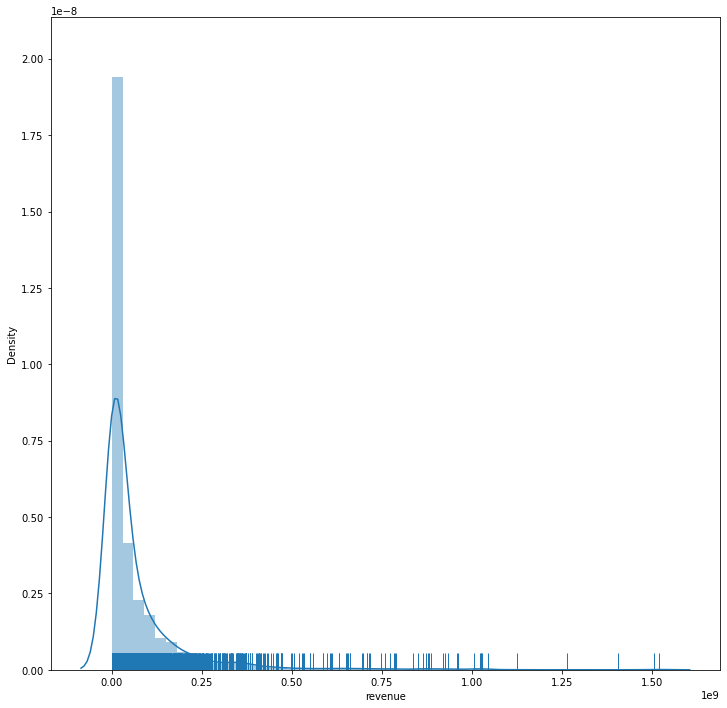

In [30]:
#view the revenue in a distplot (used to depict the distplot with different variations in it.)
plt.figure(figsize=(12,12))
sns.distplot(train_data['revenue'],rug=True)

In [ ]:
#Lets look at some plots to see how some of the data is distributed and correlated 

<AxesSubplot:xlabel='revenue', ylabel='budget'>

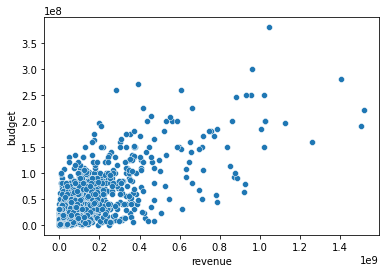

In [26]:
sns.scatterplot(x='revenue',y='budget',data=train_data)

<AxesSubplot:xlabel='revenue', ylabel='popularity'>

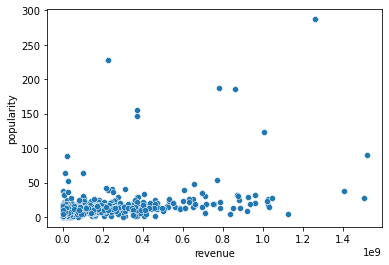

In [27]:
sns.scatterplot(x='revenue',y='popularity',data=train_data)

<AxesSubplot:xlabel='status', ylabel='count'>

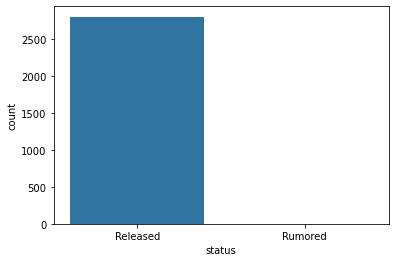

In [11]:
sns.countplot(x='status',data=train_data)

<AxesSubplot:ylabel='runtime'>

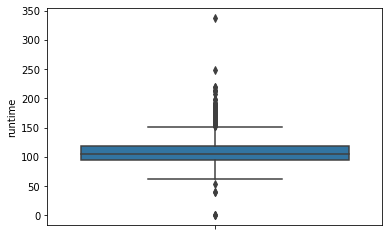

In [13]:
sns.boxplot(data=train_data,y='runtime')

<AxesSubplot:xlabel='count', ylabel='original_language'>

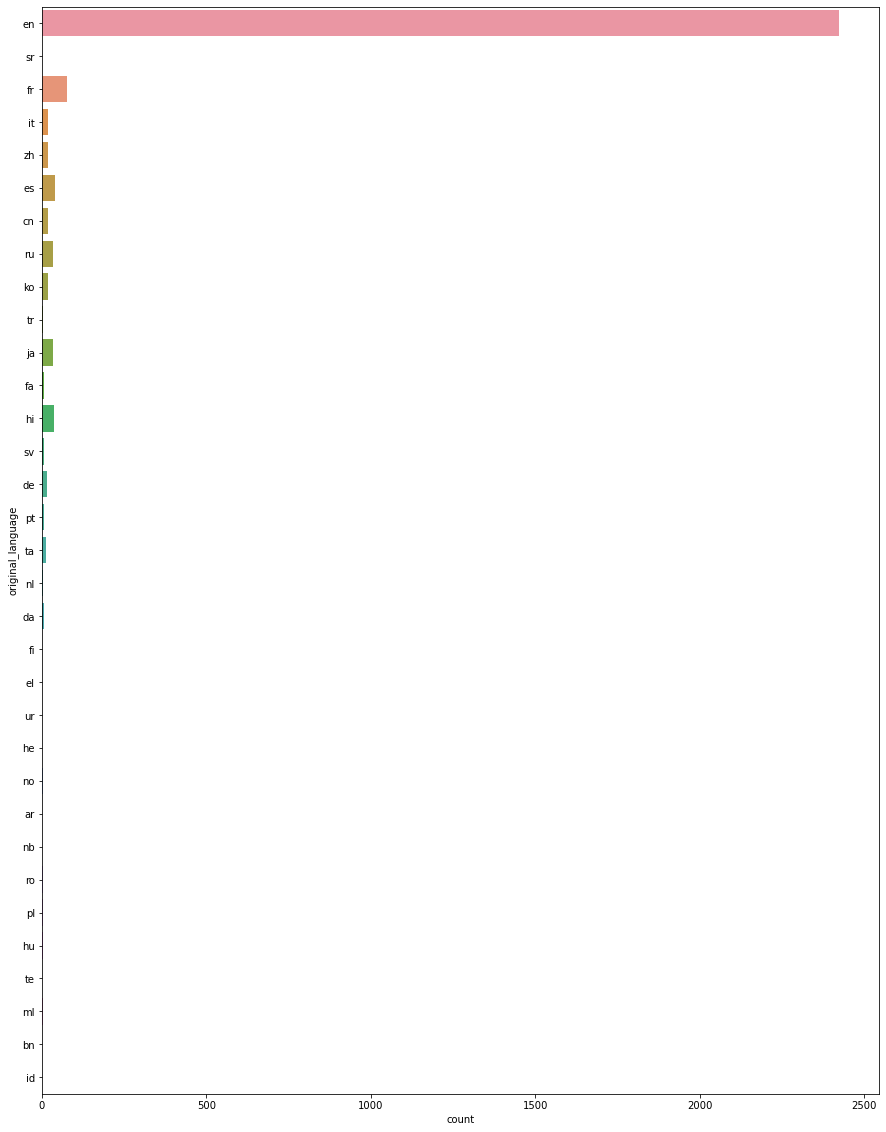

In [32]:
#we assume that en will be the highest in original language, but we can view it to get a better idead of the distribution
plt.figure(figsize=(15,20))
sns.countplot(y='original_language',data=train_data)

In [33]:
#attempt to evenly distribute revenue data with log
train_data['logrevenue'] = np.log1p(train_data['revenue'])

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='logrevenue', ylabel='Density'>

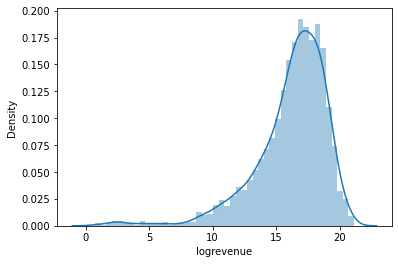

In [34]:
sns.distplot(train_data['logrevenue'])

In [ ]:
#fixing genre, production company, production country, etc 

In [36]:
train_data["genres"] = train_data.genres.astype(str)
test_data["genres"] = test_data.genres.astype(str)

In [37]:
#fix some of the value formating, pull out genres from list 
def proc_json(string, key):
    try:
        data = eval(string)
        return ",".join([d[key] for d in data])
    except:
        return ''
    
train_data.genres = train_data.genres.apply(lambda x: proc_json(x, 'name'))
test_data.genres = test_data.genres.apply(lambda x: proc_json(x, 'name'))

In [38]:
genres = []
for idx, val in train_data.genres.iteritems():
    gen_list = val.split(',')
    for gen in gen_list:
        if gen == '':
            continue

        if gen not in genres:
            genres.append(gen)

In [39]:
genres = []
for idx, val in test_data.genres.iteritems():
    gen_list = val.split(',')
    for gen in gen_list:
        if gen == '':
            continue

        if gen not in genres:
            genres.append(gen)

In [75]:
train_data['genres'].describe()

count      2801
unique      841
top       Drama
freq        249
Name: genres, dtype: object

In [76]:
test_data['genres'].describe()

count      4082
unique     1057
top       Drama
freq        319
Name: genres, dtype: object

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

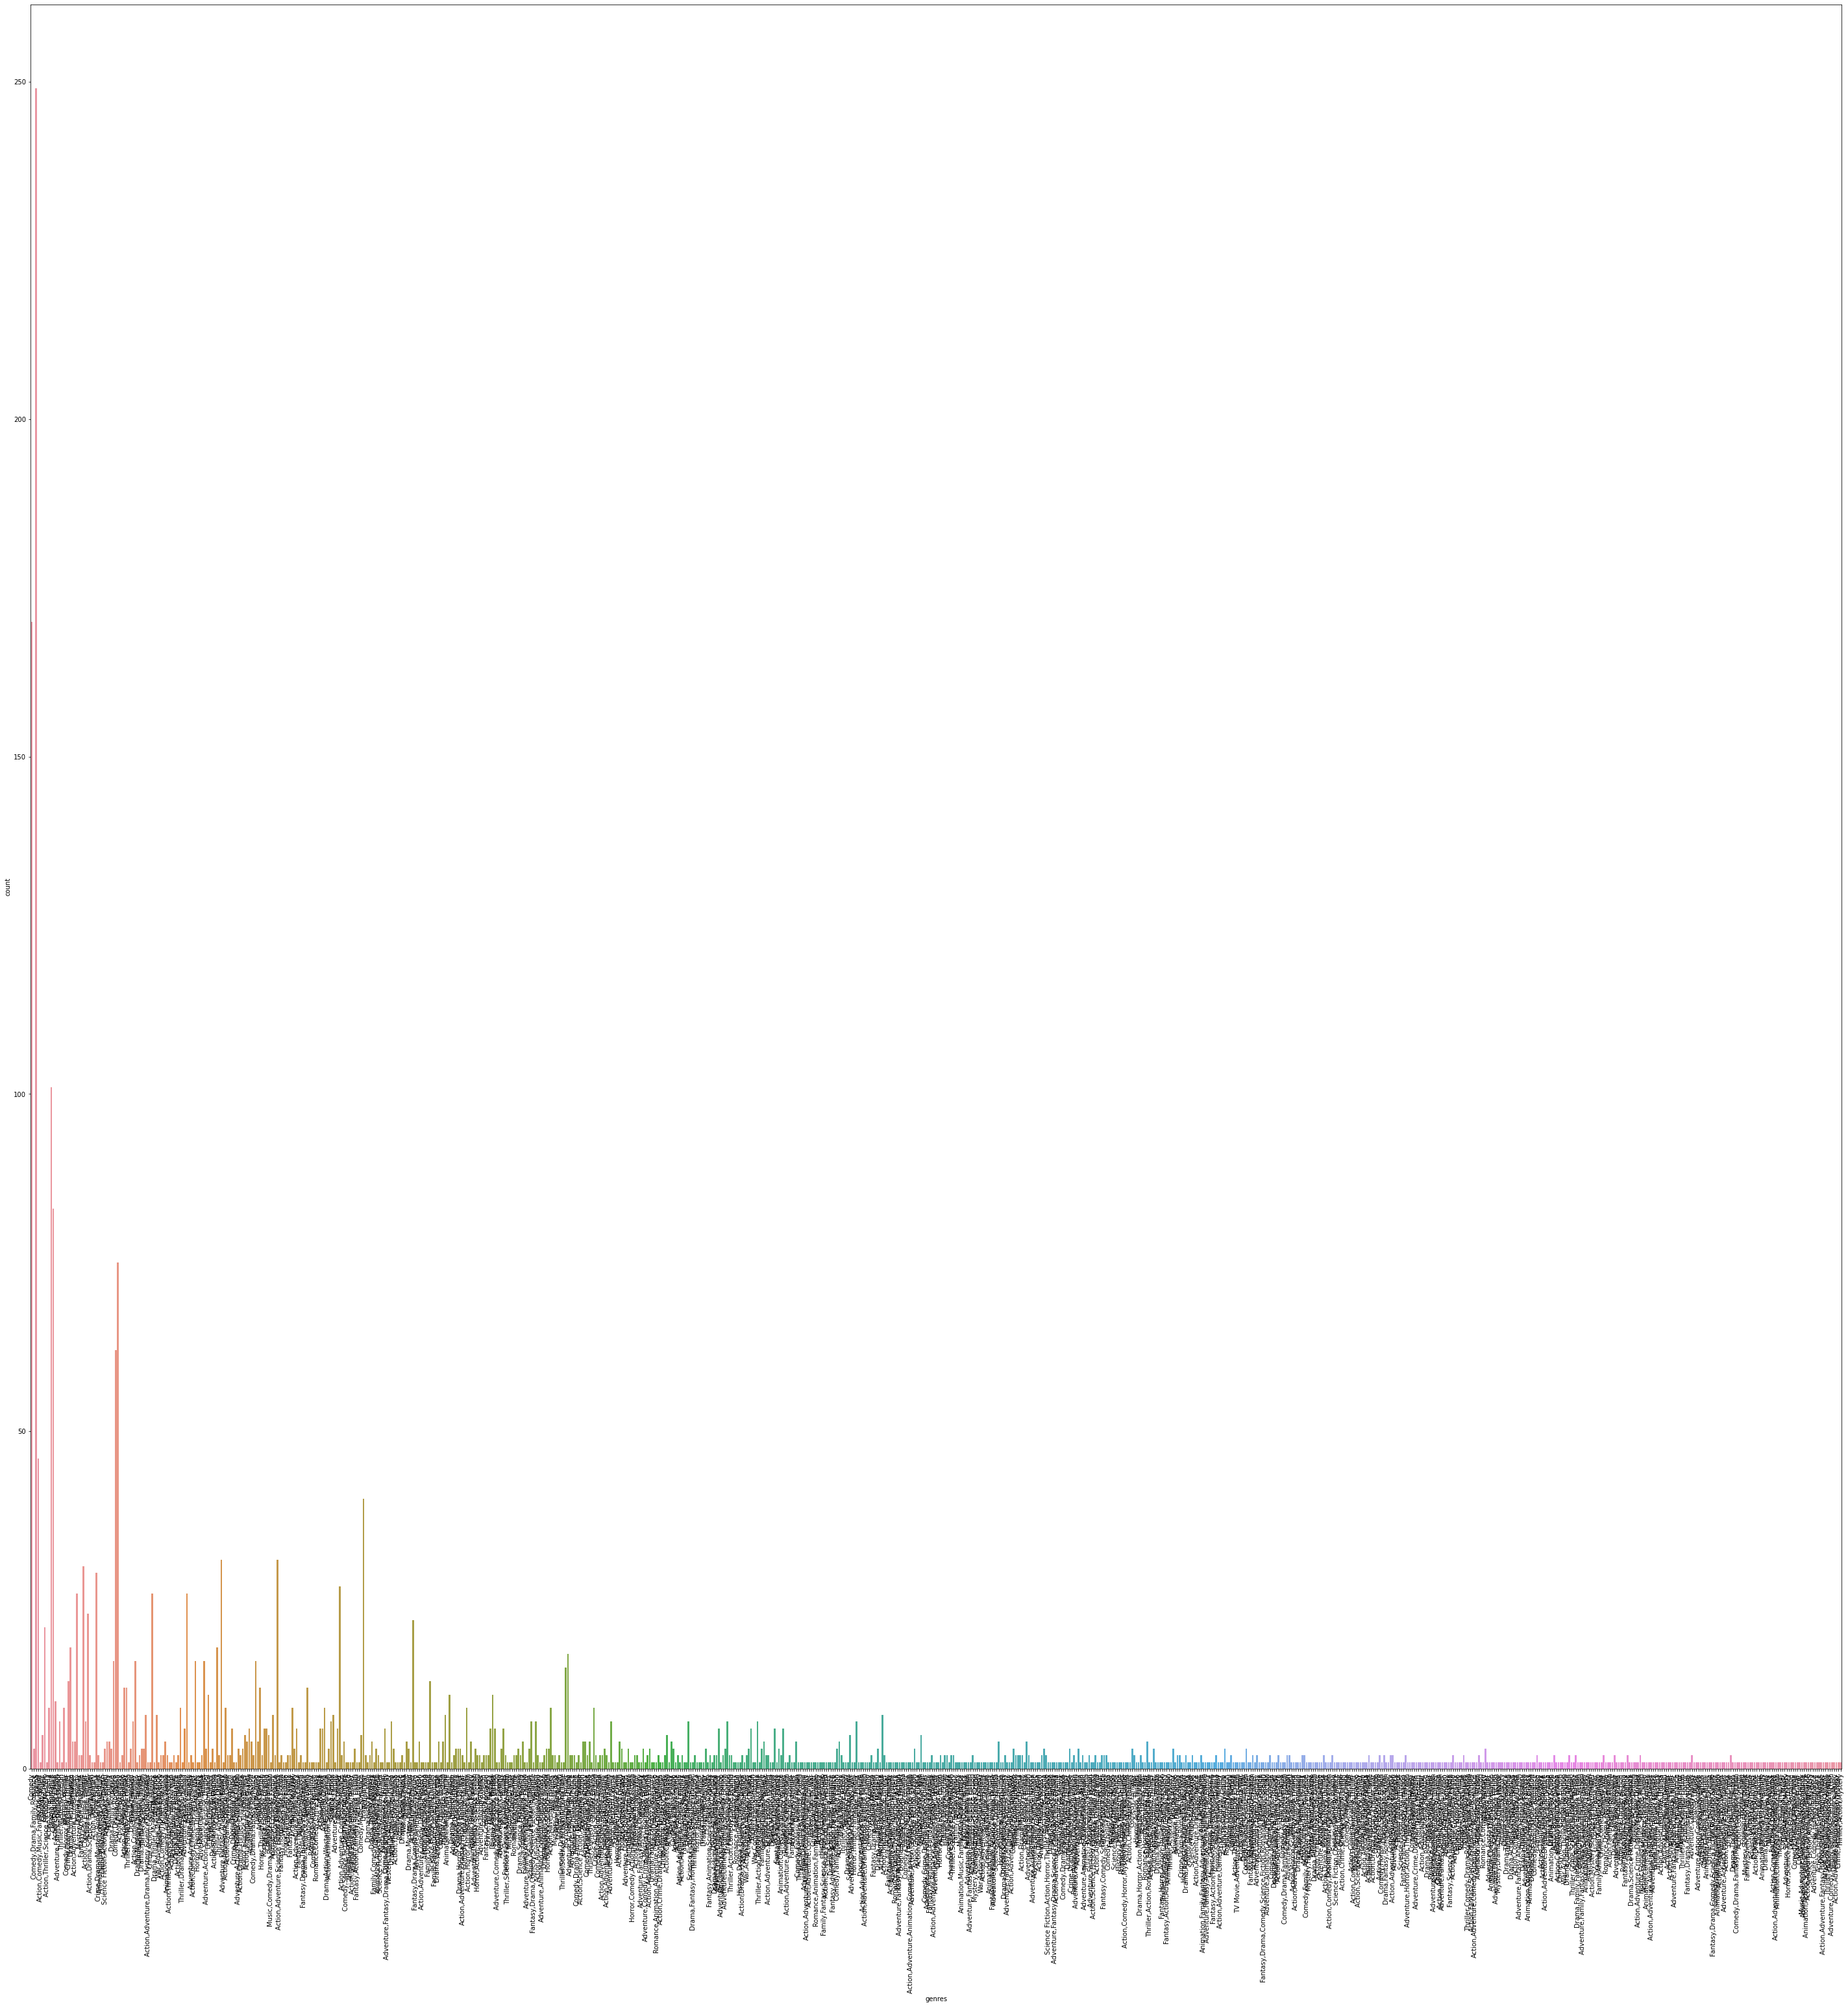

In [78]:
#looks like drama is the most popular genre 
plt.figure(figsize=(50,50))
sns.countplot(x='genres',data=train_data)
plt.xticks(rotation=90)

In [ ]:
#we should consider only keeping the first of each list

# Turning Categorical Data into Numeric 

In [47]:
#import sklearn dependencies 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [48]:
train_data.dtypes

id                        int64
genres                   object
imdb_id                  object
original_language        object
original_title           object
overview                 object
popularity              float64
poster_path              object
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
title                    object
cast                     object
budget                  float64
revenue                   int64
logrevenue              float64
dtype: object

In [49]:
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [ ]:
#first: fixing the release date

In [50]:
def calc_prevalence(y):
     return (sum(y)/len(y))

In [52]:
#converting objects that are currently numeric to float 
#converting release date to datetime

train_data["budget"] = train_data.budget.astype(float)
test_data["budget"] = test_data.budget.astype(float)


train_data["runtime"] = train_data.runtime.astype(float)
test_data["runtime"] = test_data.runtime.astype(float)

train_data["revenue"] = train_data.revenue.astype(float)

train_data["release_date"] = pd.to_datetime(train_data["release_date"])
test_data["release_date"] = pd.to_datetime(test_data["release_date"])

In [53]:
train_data["release_date"] = pd.to_datetime(train_data["release_date"], 
 format = "%Y-%m-%dT%", 
 errors = "coerce")

In [54]:
test_data["release_date"] = pd.to_datetime(test_data["release_date"], 
 format = "%Y-%m-%dT%", 
 errors = "coerce")

In [55]:
train_data["film_release_year"] = train_data["release_date"].dt.year
train_data["film_release__month"] = train_data["release_date"].dt.month
train_data["film_release__week"] = train_data["release_date"].dt.week
train_data["film_release__day"] = train_data["release_date"].dt.day

<ipython-input-55-31f70615f727>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_data["film_release__week"] = train_data["release_date"].dt.week


In [56]:
test_data["film_release_year"] = test_data["release_date"].dt.year
test_data["film_release__month"] = test_data["release_date"].dt.month
test_data["film_release__week"] = test_data["release_date"].dt.week
test_data["film_release__day"] = test_data["release_date"].dt.day

<ipython-input-56-21539e0a84f3>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_data["film_release__week"] = test_data["release_date"].dt.week


<AxesSubplot:xlabel='film_release__month', ylabel='count'>

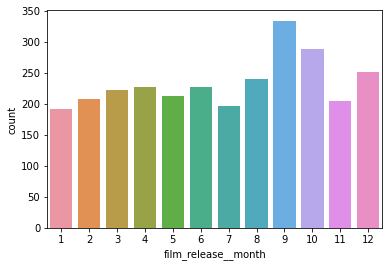

In [60]:
sns.countplot(x='film_release__month',data=train_data)

In [61]:
#It looks like the majority of films were release in September

<AxesSubplot:xlabel='film_release__day', ylabel='count'>

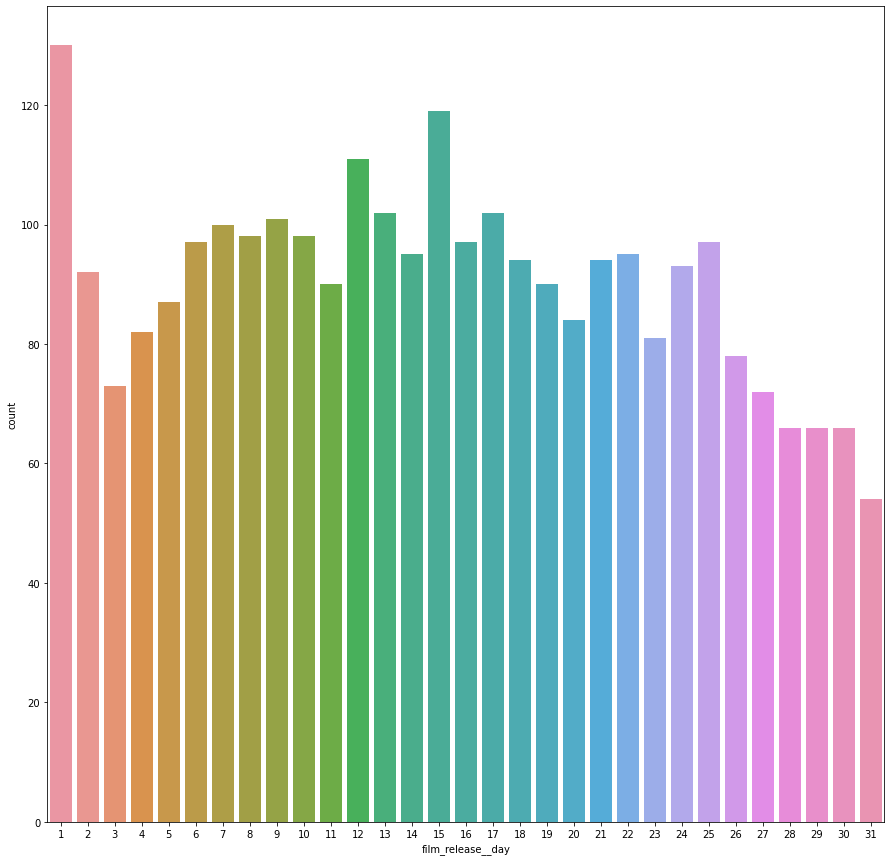

In [64]:
#Lets see about the beginning or ending of the month?
plt.figure(figsize=(15,15))
sns.countplot(x='film_release__day',data=train_data)

In [65]:
#the first day of each month is the most popular 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89]),
 [Text(0, 0, '1972'),
  Text(1, 0, '1973'),
  Text(2, 0, '1974'),
  Text(3, 0, '1975'),
  Text(4, 0, '1976'),
  Text(5, 0, '1977'),
  Text(6, 0, '1978'),
  Text(7, 0, '1979'),
  Text(8, 0, '1980'),
  Text(9, 0, '1981'),
  Text(10, 0, '1982'),
  Text(11, 0, '1983'),
  Text(12, 0, '1984'),
  Text(13, 0, '1985'),
  Text(14, 0, '1986'),
  Text(15, 0, '1987'),
  Text(16, 0, '1988'),
  Text(17, 0, '1989'),
  Text(18, 0, '1990'),
  Text(19, 0, '1991'),
  Text(20, 0, '1992'),
  Text(21, 0, '1993'),
  Text(22, 0, '1994'),
  Text(23, 0, '1995'),
  Text(24, 0, '1996'),
  Text(25, 0, '1997'),
  

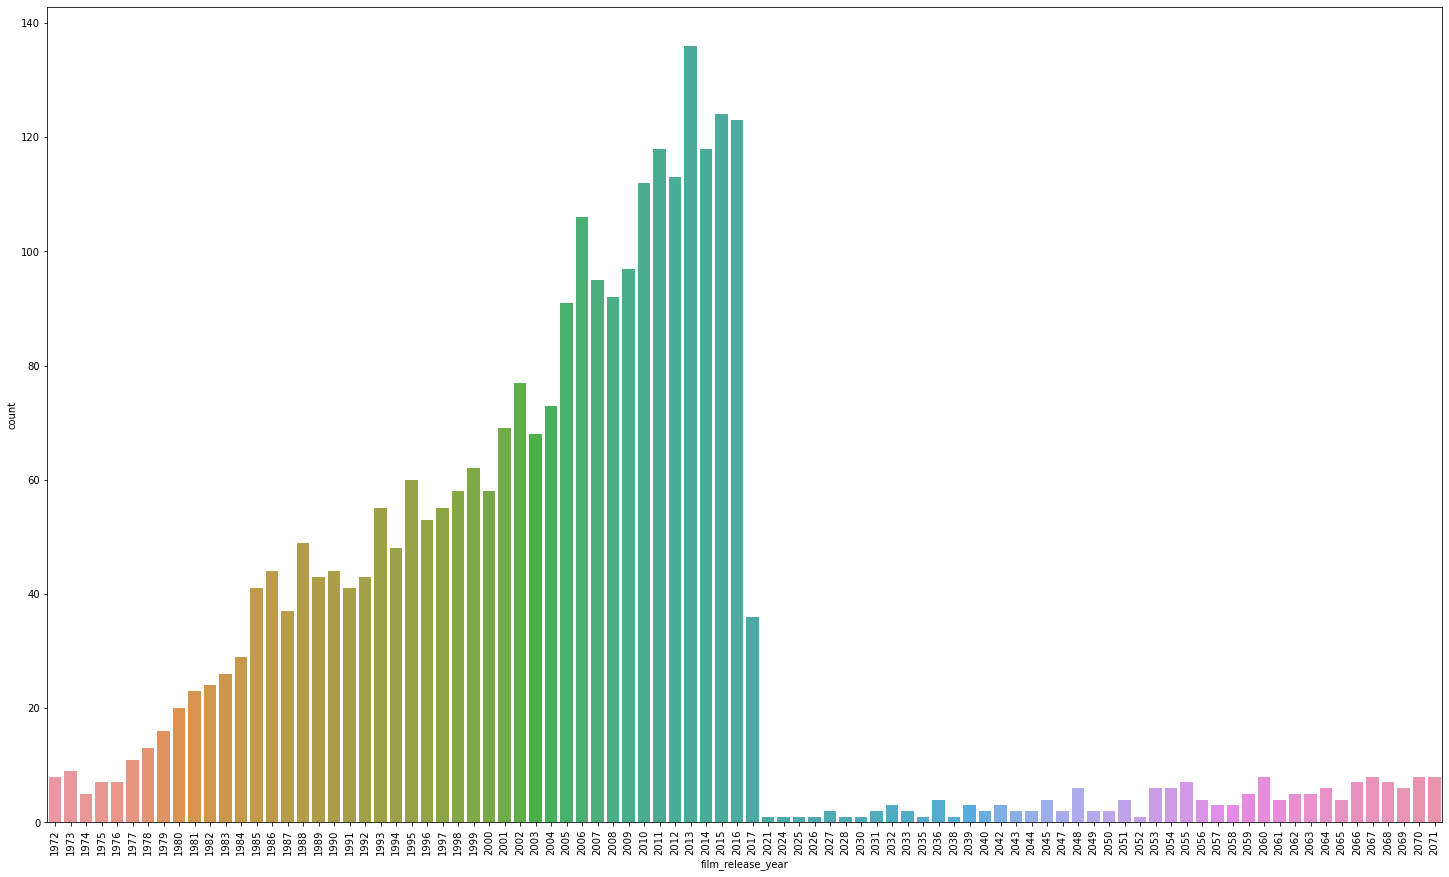

In [70]:
#release year popularity?
plt.figure(figsize=(25,15))
sns.countplot(x='film_release_year',data=train_data)
plt.xticks(rotation=90)

In [ ]:
#We can see that something does not look right with the years

In [71]:
#fix it with 
train_data['film_release_year'] = train_data['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)
test_data['film_release_year'] = test_data['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89]),
 [Text(0, 0, '1921'),
  Text(1, 0, '1924'),
  Text(2, 0, '1925'),
  Text(3, 0, '1926'),
  Text(4, 0, '1927'),
  Text(5, 0, '1928'),
  Text(6, 0, '1930'),
  Text(7, 0, '1931'),
  Text(8, 0, '1932'),
  Text(9, 0, '1933'),
  Text(10, 0, '1935'),
  Text(11, 0, '1936'),
  Text(12, 0, '1938'),
  Text(13, 0, '1939'),
  Text(14, 0, '1940'),
  Text(15, 0, '1942'),
  Text(16, 0, '1943'),
  Text(17, 0, '1944'),
  Text(18, 0, '1945'),
  Text(19, 0, '1947'),
  Text(20, 0, '1948'),
  Text(21, 0, '1949'),
  Text(22, 0, '1950'),
  Text(23, 0, '1951'),
  Text(24, 0, '1952'),
  Text(25, 0, '1953'),
  

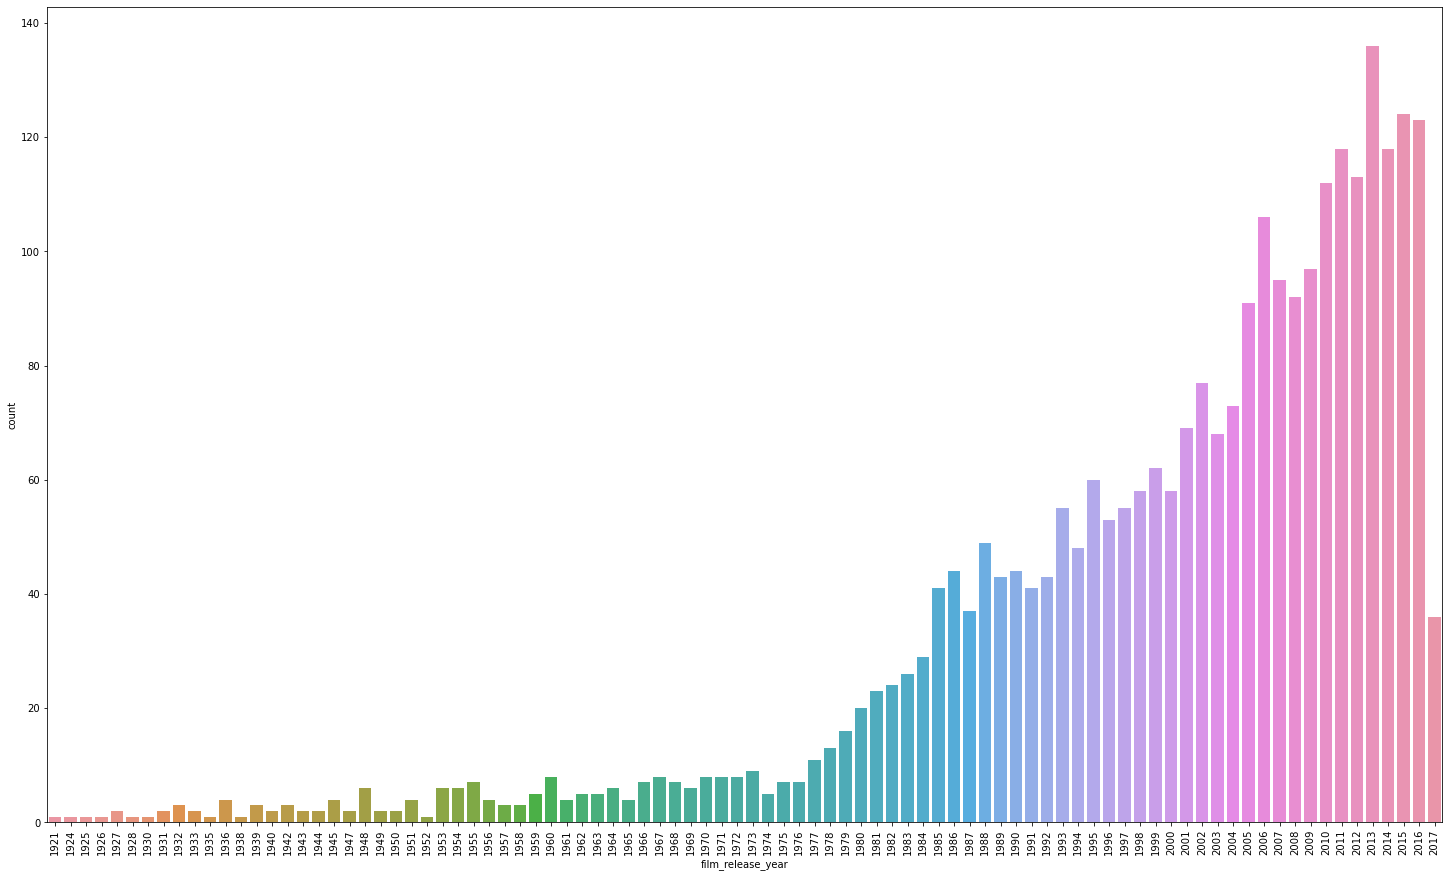

In [72]:
#make sure 
#release year popularity?
plt.figure(figsize=(25,15))
sns.countplot(x='film_release_year',data=train_data)
plt.xticks(rotation=90)

In [ ]:
#fixed!

In [67]:
#2nd: Runtime
print(len(train_data[train_data['runtime']==0]))
print(len(test_data[test_data['runtime']==0]))

0
0


In [ ]:
#fixing thos 3 '0' values in the train_data

In [66]:
train_data['runtime'].replace(0, np.nan, inplace=True)

In [68]:
train_data.dropna(inplace=True)

In [79]:
#checking correlation between budget and the other features
import scipy.stats as stats
X = train_data[train_data['budget'] != 0]
for i in X.select_dtypes(include='number', exclude='datetime'):
    print(i, stats.pearsonr(X.budget, X[i]))

id (0.013643010025932082, 0.4704417815206701)
popularity (0.2950566583030002, 2.2224739828760785e-57)
runtime (0.18746220442031297, 1.4381713562928685e-23)
budget (1.0, 0.0)
revenue (0.7088059784282759, 0.0)
logrevenue (0.3713894923712414, 2.507671260249738e-92)
index (0.013643010025932082, 0.4704417815206701)
film_release_year (0.221956324006746, 1.3294886806673574e-32)
film_release__month (0.015806464420992015, 0.40302684195703015)
film_release__week (0.011125972455879218, 0.5561352512206745)
film_release__day (0.020326399405242883, 0.282197953971266)


In [80]:
#strongest correlations
#popularity (0.2950566583030002, 2.2224739828760785e-57)
#film_release_year (0.221956324006746, 1.3294886806673574e-32)

In [94]:
#fixing poster path
train_data['poster_path'].fillna(0, inplace=True)
train_data.loc[train_data['poster_path'] != 0, 'poster_path'] = 1

test_data['poster_path'].fillna(0, inplace=True)
test_data.loc[test_data['poster_path'] != 0, 'poster_path'] = 1

In [41]:
#do the same thing we did for genre for production company, country, cast
train_data["production_countries"] = train_data.production_countries.astype(str)
train_data["production_companies"] = train_data.production_companies.astype(str)
train_data["cast"] = train_data.cast.astype(str)
test_data["production_countries"] = test_data.production_countries.astype(str)
test_data["production_companies"] = test_data.production_companies.astype(str)
test_data["cast"] = test_data.cast.astype(str)

In [394]:
def proc_json(string, key):
    try:
        data = eval(string)
        return ",".join([d[key] for d in data])
    except:
        return ''
    
all_movies.production_countries = all_movies.production_countries.apply(lambda x: proc_json(x, 'name'))
all_movies.production_companies = all_movies.production_companies.apply(lambda x: proc_json(x, 'name'))
all_movies.cast = all_movies.cast.apply(lambda x: proc_json(x, 'name'))

In [395]:
all_movies['genre_1'] = all_movies['genres'].str.split(',').str[0]
all_movies['production_company'] = all_movies['production_companies'].str.split(',').str[0]
all_movies['production_country'] = all_movies['production_countries'].str.split(',').str[0]

In [396]:
all_movies = all_movies[['revenue','film', 'budget', 'genres','genre_1','production_companies',
                       'production_company','production_countries','production_country',
                       'original_language', 'popularity', 'release_date',
                       'runtime']]

In [397]:
all_movies= all_movies.drop(columns=['genres','production_companies','production_countries'])

# Addressing Missing Values

In [398]:
all_movies.isnull().sum()

revenue               4398
film                     3
budget                   0
genre_1                  0
production_company       0
production_country       0
original_language        0
popularity               0
release_date             1
runtime                  6
dtype: int64

In [399]:
all_movies.dtypes

revenue                object
film                   object
budget                 object
genre_1                object
production_company     object
production_country     object
original_language      object
popularity            float64
release_date           object
runtime                object
dtype: object

In [401]:
#adding index column so we can remove the film name for scaling before splitting into test and train so the indexes remain true
all_movies['index'] = all_movies.index

In [406]:
#fill in missing value with random date
all_movies['release_date'] = all_movies['release_date'].fillna('6/15/10')

# Machine Learning Data Preprocessing

In [407]:
#Keep in mind that all the categorical variables are nominal so they will need to be 
#onehotencoded NOT Intenger Encoding

In [408]:
#import sklearn dependencies 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [409]:
all_movies.shape

(7818, 10)

In [410]:
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [411]:
all_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7818 entries, 0 to 7817
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   revenue             7818 non-null   float64
 1   index               7818 non-null   int64  
 2   film                7815 non-null   object 
 3   budget_processed    7818 non-null   object 
 4   genre_1             7818 non-null   object 
 5   production_company  7818 non-null   object 
 6   original_language   7818 non-null   object 
 7   popularity          7818 non-null   float64
 8   release_date        7818 non-null   object 
 9   runtime             7812 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 610.9+ KB


In [412]:
all_movies= all_movies.dropna()

In [413]:
all_movies.isnull().sum()

revenue               0
index                 0
film                  0
budget_processed      0
genre_1               0
production_company    0
original_language     0
popularity            0
release_date          0
runtime               0
dtype: int64

In [414]:
def calc_prevalence(y):
     return (sum(y)/len(y))

In [415]:
#converting objects that are currently numeric to float 
#converting release date to datetime
all_movies["index"] = all_movies.index.astype(float)
all_movies["budget_processed"] = all_movies.budget_processed.astype(float)
all_movies["runtime"] = all_movies.runtime.astype(float)
all_movies["revenue"] = all_movies.revenue.astype(float)
all_movies["release_date"] = pd.to_datetime(all_movies["release_date"])

In [416]:
all_movies["release_date"] = pd.to_datetime(all_movies["release_date"], 
 format = "%Y-%m-%dT%", 
 errors = "coerce")

In [417]:
all_movies

revenue   index                                      film  \
0      12314651.0     0.0                    Hot Tub Time Machine 2   
1      95149435.0     1.0  The Princess Diaries 2: Royal Engagement   
2      13092000.0     2.0                                  Whiplash   
3      16000000.0     3.0                                   Kahaani   
4       3923970.0     4.0                                Marine Boy   
...           ...     ...                                       ...   
7813  127000000.0  7813.0                           Halloween Kills   
7814  124005195.0  7814.0                            The King's Man   
7815  119815153.0  7815.0                       The Addams Family 2   
7816  103966489.0  7816.0                              Wrath of Man   
7817   90112510.0  7817.0                                       Old   

      budget_processed    genre_1    production_company original_language  \
0         1.400000e+07     Comedy    Paramount Pictures                en   
1         4.000000e+07     Comedy  Walt Disney Pictures                en   
2         3.300000e+06      Drama            Bold Films                en   
3         1.200000e+06   Thriller                                      hi   
4         3.277080e+07     Action                                      ko   
...                ...        ...                   ...               ...   
7813      2.000000e+07     Horror    Universal Pictures                en   
7814      1.000000e+08     Action            Marv Films                en   
7815      3.277080e+07  Animation   Metro-Goldwyn-Mayer                en   
7816      4.000000e+07     Action               Miramax                en   
7817      1.800000e+07   Thriller    Universal Pictures                en   

       popularity release_date  runtime  
0        6.575393   2015-02-20     93.0  
1        8.248895   2004-08-06    113.0  
2       64.299990   2014-10-10    105.0  
3        3.174936   2012-03-09    122.0  
4        1.148070   2009-02-05    118.0  
...           ...          ...      ...  
7813   294.306000   2021-10-14    105.0  
7814  2962.384000   2021-12-22    131.0  
7815   298.425000   2021-10-01     93.0  
7816   338.664000   2021-04-22    119.0  
7817   249.306000   2021-07-21    108.0  

[7809 rows x 10 columns]

In [418]:
all_movies["film_release_year"] = all_movies["release_date"].dt.year
all_movies["film_release__month"] = all_movies["release_date"].dt.month
all_movies["film_release__week"] = all_movies["release_date"].dt.week
all_movies["film_release__day"] = all_movies["release_date"].dt.dayofyear

<ipython-input-418-b50ec28e08b6>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  all_movies["film_release__week"] = all_movies["release_date"].dt.week


# Converting Categorical Data to numeric with OneHotEncoding 
We need to convert:
- genre
- production company
- production country
- original language 

In [423]:
all_movies.dtypes

revenue                       float64
index                         float64
film                           object
budget_processed              float64
genre_1                        object
production_company             object
original_language              object
popularity                    float64
release_date           datetime64[ns]
runtime                       float64
film_release__month             int64
film_release__week              int64
film_release__day               int64
dtype: object

In [424]:
all_movies= all_movies.drop(columns=['film_release_year'])
all_movies= all_movies.drop(columns=['film_release__month'])
all_movies= all_movies.drop(columns=['film_release__week'])
all_movies= all_movies.drop(columns=['release_date'])

In [425]:
#rename genre_1 to genres
all_movies.rename(columns={'genre_1': 'genres'}, inplace=True)

In [426]:
#creating numerical data for the genre column 
genre_column_names = []
for gen in genres:
    col_name = 'genre_' + gen.replace(' ', '_')
    all_movies[col_name] = all_movies.genres.str.contains(gen).astype('uint8')
    genre_column_names.append(col_name)

In [427]:
all_movies = pd.get_dummies(all_movies, columns = ["original_language"])

In [428]:
all_movies = pd.get_dummies(all_movies, columns = ["production_company"])

In [429]:
all_movies

revenue   index                                      film  \
0      12314651.0     0.0                    Hot Tub Time Machine 2   
1      95149435.0     1.0  The Princess Diaries 2: Royal Engagement   
2      13092000.0     2.0                                  Whiplash   
3      16000000.0     3.0                                   Kahaani   
4       3923970.0     4.0                                Marine Boy   
...           ...     ...                                       ...   
7813  127000000.0  7813.0                           Halloween Kills   
7814  124005195.0  7814.0                            The King's Man   
7815  119815153.0  7815.0                       The Addams Family 2   
7816  103966489.0  7816.0                              Wrath of Man   
7817   90112510.0  7817.0                                       Old   

      budget_processed     genres   popularity  runtime  film_release__day  \
0         1.400000e+07     Comedy     6.575393     93.0                 51   
1         4.000000e+07     Comedy     8.248895    113.0                219   
2         3.300000e+06      Drama    64.299990    105.0                283   
3         1.200000e+06   Thriller     3.174936    122.0                 69   
4         3.277080e+07     Action     1.148070    118.0                 36   
...                ...        ...          ...      ...                ...   
7813      2.000000e+07     Horror   294.306000    105.0                287   
7814      1.000000e+08     Action  2962.384000    131.0                356   
7815      3.277080e+07  Animation   298.425000     93.0                274   
7816      4.000000e+07     Action   338.664000    119.0                112   
7817      1.800000e+07   Thriller   249.306000    108.0                202   

      genre_Comedy  genre_Drama  genre_Family  genre_Romance  genre_Thriller  \
0                1            0             0              0               0   
1                1            0             0              0               0   
2                0            1             0              0               0   
3                0            0             0              0               1   
4                0            0             0              0               0   
...            ...          ...           ...            ...             ...   
7813             0            0             0              0               0   
7814             0            0             0              0               0   
7815             0            0             0              0               0   
7816             0            0             0              0               0   
7817             0            0             0              0               1   

      genre_Action  genre_Animation  genre_Adventure  genre_Horror  \
0                0                0                0             0   
1                0                0                0             0   
2                0                0                0             0   
3                0                0                0             0   
4                1                0                0             0   
...            ...              ...              ...           ...   
7813             0                0                0             1   
7814             1                0                0             0   
7815             0                1                0             0   
7816             1                0                0             0   
7817             0                0                0             0   

      genre_Documentary  genre_Music  genre_Crime  genre_Science_Fiction  \
0                     0            0            0                      0   
1                     0            0            0                      0   
2                     0            0            0                      0   
3                     0            0            0                      0   
4                     0            0  

In [451]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
data = [X_train_scaled, X_test_scaled, y_train, y_test]

ValueError: could not convert string to float: 'Ikiru'

In [452]:
pls_work= all_movies.copy()

# Train and Test Split

Next we will need to perform a test train split. 
After data is split drop the revenue column from the test data because that will be our target variable in our models

In [158]:
#consider dropping popularity column because that is measured after the film is released

In [453]:
pls_work= pls_work.drop(columns=['film'])
pls_work= pls_work.drop(columns=['genres'])
pls_work= pls_work.drop(columns=['index'])

In [457]:
X = pls_work.iloc[:, 1:2200].values
y = pls_work.iloc[:, -1].values

In [458]:
X = pd.DataFrame(X)

In [462]:
def test_model(model, data):
    X_train_scaled, X_test_scaled, y_train, y_test = data
    reg = model.fit(X_train_scaled, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train_scaled, y_train)}')
    print(f'Test Score: {reg.score(X_test_scaled, y_test)}\n')
    plt.show()   

In [466]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
data = [X_train_scaled, X_test_scaled, y_train, y_test]

In [460]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR

In [465]:
test_model(LinearRegression(), data)

test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)

Model: LinearRegression
Train score: 1.0
Test Score: 0.0

Model: KNeighborsRegressor
Train score: 0.35989069171648147
Test Score: 1.0

Model: RandomForestRegressor
Train score: 0.8235698719043552
Test Score: 1.0

Model: ExtraTreesRegressor
Train score: 1.0
Test Score: 1.0

Model: AdaBoostRegressor
Train score: -0.00017079419299759202
Test Score: 1.0

Model: SVR
Train score: -231.01114076344416
Test Score: 0.0



In [433]:
train=pls_work.sample(frac=0.75,random_state=42) #random state is a seed value
test=pls_work.drop(train.index)

In [434]:
y_train = train["revenue"]
X_train = train.drop(columns = ["revenue"])
X_train.head()

budget_processed  popularity  runtime  film_release__day  genre_Comedy  \
3964        70000000.0   10.404277     97.0                304             0   
7392       155000000.0   30.188198    126.0                174             0   
6286        10000000.0    6.383512     92.0                220             0   
586          1500000.0    0.446454    162.0                316             0   
7194        20000000.0    5.682129     83.0                 48             1   

      genre_Drama  genre_Family  genre_Romance  genre_Thriller  genre_Action  \
3964            0             0              0               0             1   
7392            0             0              0               0             0   
6286            1             0              0               0             0   
586             0             0              0               0             0   
7194            0             0              0               0             0   

      genre_Animation  genre_Adventure  genre_Horror  genre_Documentary  \
3964                0                0             0                  0   
7392                0                0             0                  0   
6286                0                0             0                  0   
586                 0                0             0                  0   
7194                0                0             0                  0   

      genre_Music  genre_Crime  genre_Science_Fiction  genre_Mystery  \
3964            0            0                      0              0   
7392            0            0                      1              0   
6286            0            0                      0              0   
586             1            0                      0              0   
7194            0            0                      0              0   

      genre_Foreign  genre_Fantasy  genre_War  genre_Western  genre_History  \
3964              0              0          0              0              0   
7392              0              0          0              0              0   
6286              0              0          0              0              0   
586               0              0          0              0              0   
7194              0              0          0              0              0   

      genre_TV_Movie  original_language_af  original_language_ar  \
3964               0                     0                     0   
7392               0                     0                     0   
6286               0                     0                     0   
586                0                     0                     0   
7194               0                     0                     0   

      original_language_bm  original_language_bn  original_language_ca  \
3964                     0                     0                     0   
7392                     0                     0                     0   
6286                     0                     0                     0   
586                      0                     0                     0   
7194                     0                     0                     0   

      original_language_cn  original_language_cs  original_language_da  \
3964                     0                     0                     0   
7392                     0                     0                     0   
6286                     0                     0                     0   
586                      0                     0                     0   
7194                     0                     0                     0   

      original_language_de  original_language_el  original_language_en  \
3964                     0                     0                     1   
7392                     0                     0                     1   
6286                     0                     0                     1   
586                      0                     0                     0   
7194            

In [435]:
#drop Revenue column from TEST df because that will be our target variable
y_test = test["revenue"]
X_test = test.drop(columns = ["revenue"])
X_test.head()

budget_processed  popularity  runtime  film_release__day  genre_Comedy  \
2      3.300000e+06   64.299990    105.0                283             0   
3      1.200000e+06    3.174936    122.0                 69             0   
4      3.277080e+07    1.148070    118.0                 36             0   
5      8.000000e+06    0.743274     83.0                218             0   
9      6.000000e+06    4.672036     91.0                106             1   

   genre_Drama  genre_Family  genre_Romance  genre_Thriller  genre_Action  \
2            1             0              0               0             0   
3            0             0              0               1             0   
4            0             0              0               0             1   
5            0             0              0               0             0   
9            0             0              0               0             0   

   genre_Animation  genre_Adventure  genre_Horror  genre_Documentary  \
2                0                0             0                  0   
3                0                0             0                  0   
4                0                0             0                  0   
5                1                0             0                  0   
9                0                0             0                  0   

   genre_Music  genre_Crime  genre_Science_Fiction  genre_Mystery  \
2            0            0                      0              0   
3            0            0                      0              0   
4            0            0                      0              0   
5            0            0                      0              0   
9            0            0                      0              0   

   genre_Foreign  genre_Fantasy  genre_War  genre_Western  genre_History  \
2              0              0          0              0              0   
3              0              0          0              0              0   
4              0              0          0              0              0   
5              0              0          0              0              0   
9              0              0          0              0              0   

   genre_TV_Movie  original_language_af  original_language_ar  \
2               0                     0                     0   
3               0                     0                     0   
4               0                     0                     0   
5               0                     0                     0   
9               0                     0                     0   

   original_language_bm  original_language_bn  original_language_ca  \
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   
5                     0                     0                     0   
9                     0                     0                     0   

   original_language_cn  original_language_cs  original_language_da  \
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   
5                     0                     0                     0   
9                     0                     0                     0   

   original_language_de  original_language_el  original_language_en  \
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     0   
5                     0                     0                     1   
9                     0                     0                     1   

   original_language_es  original_language_fa  original_language_fi  \
2                     0      

In [102]:
X = pls_work.iloc[:, 1:-2].values
y = pls_work.iloc[:, -1].values

In [317]:
#take a look at the shape of our data
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print ('---------------------------------------------')
print ('The test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

The train data has 5864 rows and 2206 columns
---------------------------------------------
The test data has 1954 rows and 2206 columns


In [318]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Without Scaling

In [324]:
pls_work.dtypes

revenue                             float64
index                               float64
budget_processed                    float64
popularity                          float64
runtime                             float64
                                     ...   
production_company_Леополис           uint8
production_company_Наше Кино          uint8
production_company_Роскинопрокат      uint8
production_company_СТВ                uint8
production_company_Фокс               uint8
Length: 2205, dtype: object

In [ ]:
# add missing dummy variables to testing set (in training only)
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

In [436]:
reg = RandomForestClassifier().fit(X_train, y_train)
reg.score(X_test, y_test)

0.586577868852459

# With Scaling

In [441]:
# add missing dummy variables to testing set (in training only)
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

In [442]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [443]:
# Train a Random Forest Classifier model on the scaled data and print the model score
randomForestClass_scaled = RandomForestClassifier(random_state=0)
randomForestClass_scaled.fit(X_train_scaled, y_train)
print("RandomForestClassifier scaled score: ", randomForestClass_scaled.score(X_test_scaled, y_test))

RandomForestClassifier scaled score:  0.5881147540983607


In [440]:
#take a look at the shape of our data
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print ('---------------------------------------------')
print ('The test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

The train data has 5857 rows and 2197 columns
---------------------------------------------
The test data has 1952 rows and 2197 columns


In [444]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [445]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

-4146910.514037825

In [446]:
logisticRegr_scaled = LogisticRegression(
    solver='lbfgs',
    max_iter=100,
    random_state=0
)
logisticRegr_scaled.fit(X_train_scaled, y_train)
print("LogisticRegressin scaled score: ", logisticRegr_scaled.score(X_test_scaled, y_test))

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressin scaled score:  0.5281762295081968


In [448]:
meredith_df

revenue  index                                      film  \
0      12314651.0      0                    Hot Tub Time Machine 2   
1      95149435.0      1  The Princess Diaries 2: Royal Engagement   
2      13092000.0      2                                  Whiplash   
3      16000000.0      3                                   Kahaani   
4       3923970.0      4                                Marine Boy   
...           ...    ...                                       ...   
7813  127000000.0   7813                           Halloween Kills   
7814  124005195.0   7814                            The King's Man   
7815  119815153.0   7815                       The Addams Family 2   
7816  103966489.0   7816                              Wrath of Man   
7817   90112510.0   7817                                       Old   

     budget_processed    genre_1    production_company original_language  \
0            14000000     Comedy    Paramount Pictures                en   
1            40000000     Comedy  Walt Disney Pictures                en   
2             3300000      Drama            Bold Films                en   
3             1200000   Thriller                                      hi   
4     32770798.750578     Action                                      ko   
...               ...        ...                   ...               ...   
7813         20000000     Horror    Universal Pictures                en   
7814        100000000     Action            Marv Films                en   
7815  32770798.750578  Animation   Metro-Goldwyn-Mayer                en   
7816         40000000     Action               Miramax                en   
7817         18000000   Thriller    Universal Pictures                en   

       popularity release_date runtime  
0        6.575393      2/20/15    93.0  
1        8.248895       8/6/04   113.0  
2       64.299990     10/10/14   105.0  
3        3.174936       3/9/12   122.0  
4        1.148070       2/5/09   118.0  
...           ...          ...     ...  
7813   294.306000     10/14/21     105  
7814  2962.384000     12/22/21     131  
7815   298.425000     10/01/21      93  
7816   338.664000     04/22/21     119  
7817   249.306000     07/21/21     108  

[7809 rows x 10 columns]

In [ ]:
X = pls_work.iloc[:, 1:-2].values
y = pls_work.iloc[:, 0].values